## Computer vision approach for DM airpressure task

Goal is to approach create the model for pump failure detection as computer vision task - individual series of mesurements will be saved as images and deep classification cnn we be treined to infer the decion about pump failure from these images.   

Please note: Some parts of the notebook are not as well described as in the tabular_data approach. For example selection of optimal threshold for label classification. Please check that notebook first before going through this one :) 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

np.random.seed(42)

from sklearn.metrics import (confusion_matrix, f1_score, precisison_score,
                             recall_score, roc_auc_score)

from datamole_airpressure.common.Metrics import Metrics
from datamole_airpressure.computer_vision.cnn_model import VisionModel
from datamole_airpressure.computer_vision.dataset import (TorchDataset,
                                                          save_images)

In [35]:
labels_path = "/content/drive/MyDrive/Colab Notebooks/labels.csv"
data_path = "/content/drive/MyDrive/Colab Notebooks/data.parquet"
labels = pd.read_csv(labels_path)
data =  pd.read_parquet(data_path, engine='pyarrow')

### Target distribution

False    0.874858
True     0.107431
NaN      0.017710
Name: PumpFailed, dtype: float64

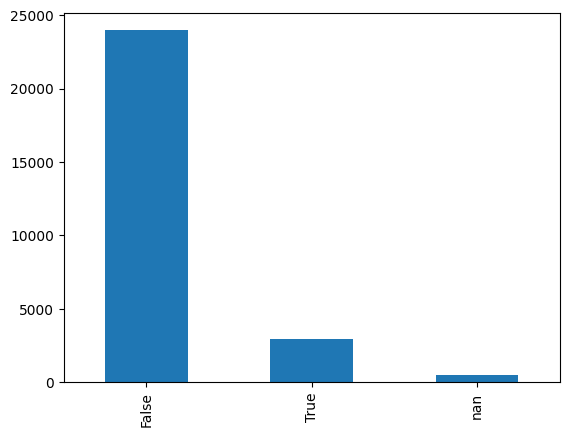

In [36]:
labels['PumpFailed'].value_counts(dropna = False).plot(kind='bar')
labels['PumpFailed'].value_counts(dropna = False)/len(labels)

In [ ]:
labels = labels[labels['PumpFailed'].notnull()].reset_index(drop = True)
labels['random'] = np.random.random(size=labels.shape[0])
labels_train = labels[labels['random']<=0.7].reset_index(drop = True)
labels_test = labels[labels['random']>0.7].reset_index(drop = True)

#### Plot 2 series of measurements without pump failed and 2 with pumpfailed.

machine_id: 0_0_0, measurement_id:0
No observatons:
(368,)
  MachineId  MeasurementId PumpFailed SlowStart SlowEnd   random
0     0_0_0              0      False     False   False  0.37454


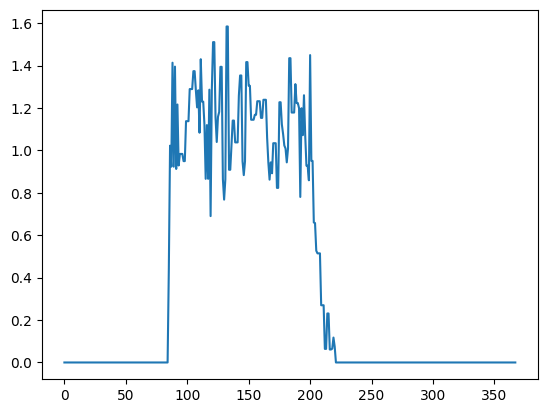

In [ ]:
show_series(data, labels, '0_0_0', 0)

machine_id: 0_0_2, measurement_id:0
No observatons:
(368,)
  MachineId  MeasurementId PumpFailed SlowStart SlowEnd    random
1     0_0_2              0      False     False   False  0.950714


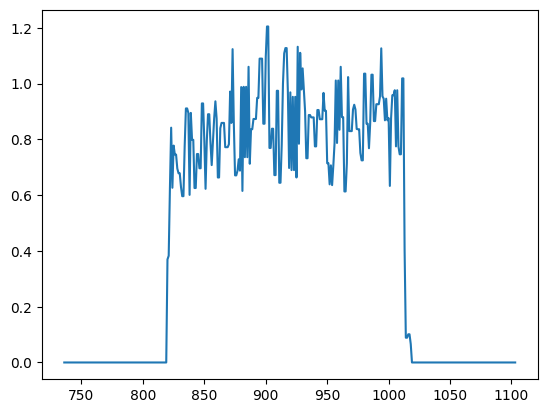

In [ ]:
show_series(data, labels, '0_0_2', 0)

machine_id: 0_0_3, measurement_id:0
No observatons:
(368,)
  MachineId  MeasurementId PumpFailed SlowStart SlowEnd    random
2     0_0_3              0       True     False   False  0.731994


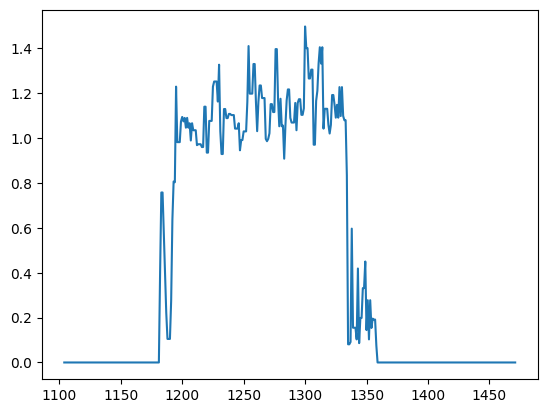

In [ ]:
show_series(data, labels, '0_0_3', 0)

machine_id: 0_1_1, measurement_id:1
No observatons:
(353,)
  MachineId  MeasurementId PumpFailed SlowStart SlowEnd    random
3     0_1_1              1       True     False   False  0.598658


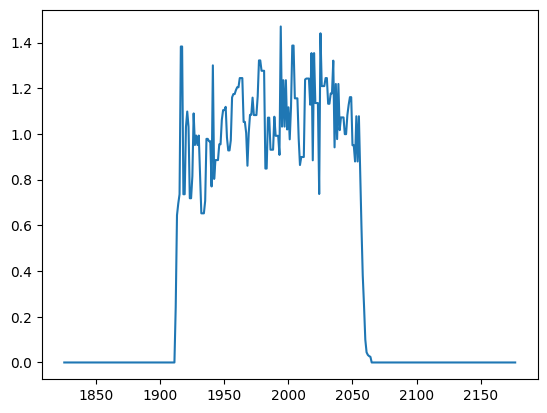

In [ ]:
show_series(data, labels, '0_1_1', 1 )

Method for classification of these images will be build.

All images were saved on disc in png format with method save_images from
#from datamole_airpressure.computer_vision.dataset import save_images

## Fitting of the CNN model

Core of the model is famous model called resnet50 - convolutional neural network with 50 layers, where some of the are so called 'residual' (carries identity for vanishing gradient prevention).

Model was pretrained on imagenet dataset and is still even in 2023 super popular for computer vision tasks. We will finetune it on downstream task.
AS the optimizer is chosen AdamW optimizer, and as we are dealing with binary classification , standard log-loss is optimized.

In [ ]:
model_config = {
    "num_epochs": 15,
    "train_batch_size": 32,
    "test_batch_size": 32,
}

In [ ]:
model = VisionModel(model_config)


In [ ]:
results_dict = model.fit(labels_train, ret_results = True)

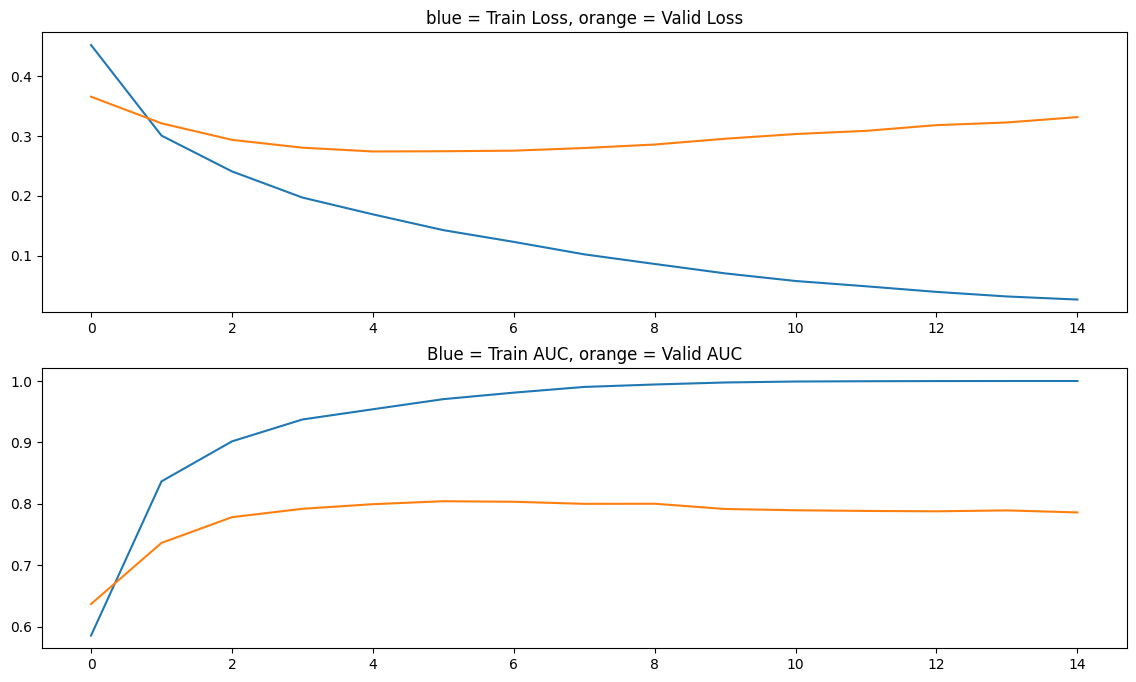

In [ ]:
model.visualise_results()

In [ ]:
# Fit model again with 5 epochs (number 4 on the x-axis, because it starts from 0), where was the best valid loss and AUC

In [ ]:
model_config = {
    "num_epochs": 5,
    "train_batch_size": 32,
    "test_batch_size": 32,
}
model = VisionModel(model_config)

In [ ]:
results_dict = model.fit(labels_train, ret_results = True)

In [ ]:
test_predictions_proba, test_predictions_label, test_target = model.predict(labels_test)

### Evaluate on validation dataset (taken as 70 percent of the train dataset). 

In [ ]:
valid_metrics = Metrics(results_dict['epoch_4']['valid_target'], results_dict['epoch_4']['valid_predictions'])

In [ ]:
valid_metrics.calculate_stats()

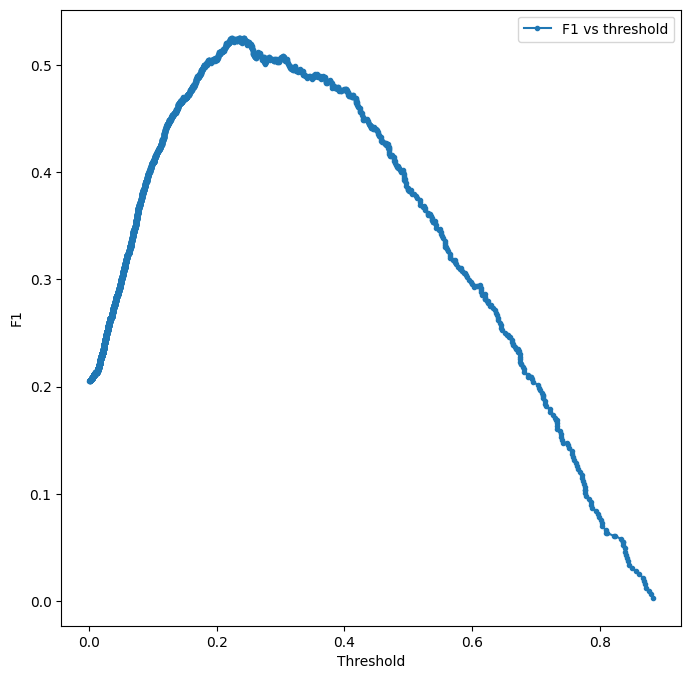

In [ ]:
valid_metrics.plot_F1_vs_threshold()

In [ ]:
print(f'Optimal threshold is {valid_metrics.threshold}')
threshold_to_use = valid_metrics.threshold

Optimal threshold is 0.23628146946430206


In [ ]:
valid_metrics.calculate_label_predictions()
valid_metrics.print_all_metrics()

Area under ROC curve:
0.7979235251461538
F1 score:
0.5242566510172143
Precision
0.52099533437014
Recall:
0.5275590551181102
Confusion Matrix:
[[4600  308]
 [ 300  335]]


### Evaluation on test dataset. Test set is completely same as in tabular data approach for the better comparison.

In [ ]:
test_metrics = Metrics(test_target, test_predictions_proba, threshold = threshold_to_use)

In [ ]:
test_metrics.calculate_label_predictions()
test_metrics.print_all_metrics()
print('Number of positives predicted:')
print(test_metrics.data['Predicted_label'].sum())

Area under ROC curve:
0.92098982861938
F1 score:
0.6143557735176103
Precision
0.49927536231884057
Recall:
0.7983777520278099
Confusion Matrix:
[[6495  691]
 [ 174  689]]
Number of positives predicted:
1380


For the sake of curiosity, lets calculate F1 score and confusion matrix based on the label predictions directly from model. 
Previously, the we took the probability of the pumpfailure and according to the calculated threshold, the label was predicted.

But this model allows direct label classification - Because model inside calculates linear score for both targets 0 and 1. In the previous sep, we apply softmax function to expract probability of target 1. But we don't have to do this, it is just possible to take as a predicted label the label with higher liner score:

In [ ]:
print('f1 score')
print(f1_score(test_target, test_predictions_label))
print('confusion matrix')
print(confusion_matrix(test_target, test_predictions_label))
print('precision')
print(precision_score(test_target, test_predictions_label))
print('recall')
print(recall_score(test_target, test_predictions_label))
print('Number of positives predicted:')
print(sum(test_predictions_label))

f1 score
0.683221476510067
confusion matrix
[[7068  118]
 [ 354  509]]
precision
0.8118022328548644
recall
0.589803012746234
Number of positives predicted:
627


We can see that this approach gives us higher F1 score. But the differences between presicions and recalls from both approaches are super drastical.This is done by the fact predict much smaller about cases as positive one, in other words model is much more strict for the prediction of the positive cases, therefore it has much higher precision (lower amount of FP cases), but ,much lower recall (lower amount of total TP cases).